In [22]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from itertools import combinations

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

def abs_dis(a, b, target):
    return abs(np.linalg.norm(np.array(a) - np.array(b)) - target)

In [2]:
coord = []
for j in range(3):
    for k in range(3):
        rand1 = np.random.rand()*0.5-1/4
        rand2 = np.random.rand()*0.5-1/4
        coord.append([1.15*j+rand1, 1.15*k+rand2])

coord = np.array(coord)
atom_ind = np.random.choice(9, 5)
coord[atom_ind]

array([[ 2.4464479 ,  2.30386771],
       [ 1.36327971,  0.95785306],
       [ 1.36327971,  0.95785306],
       [ 2.37987058,  1.12415801],
       [-0.03764879,  2.3969778 ]])

In [3]:
a = np.array([
    [2, 3],
    [3, 4]
])

alpha = np.array([1.5, 2]).reshape(-1, 1)
b = np.array([1,2])
np.random.choice(9, 9, replace=False)

array([2, 8, 3, 0, 1, 6, 7, 5, 4])

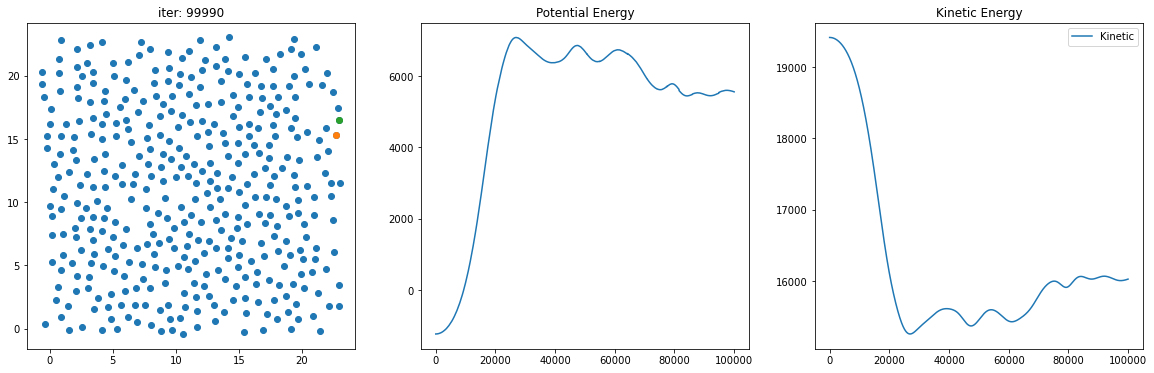

In [60]:
#*Taking gradient of x, y coordinates in square cluster
def e_(epsilon, sigma, r):
    r_cut = 2**(1/6*sigma)
    ind_exe = np.where(r > r_cut)[0]
    phi = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    grad = 4*epsilon*(12/sigma*((sigma/r)**13) - 6/sigma*((sigma/r)**7))
    grad[ind_exe[0]] = 0
    # grad = np.clip(grad, None, 5)
    return phi, grad

def cutoff(r, r1=2.49, r2=3.516):
    if r <= r1:
        r_ = 1
    if r1 < r <= r2:
        r_ = 1/2*(1+math.cos(math.pi*(r-r1)/(r2-r1)))
    elif r > r2:
        r_ = 0

    return r_

#*Generating random distributed atoms in matrix
coord, region = [], []
x_extend, y_extend = 20, 20
atom_num = x_extend*y_extend
init_dis = 1.12

for j in range(x_extend):
    for k in range(y_extend):
        rand1 = np.random.rand()*1/4-1/8
        rand2 = np.random.rand()*1/4-1/8
        coord.append([init_dis*j+rand1, init_dis*k+rand2])
        #*Seperate the matrix into several bounded regions
        # region.append([1.12*(j-1/2), 1.12*(j+1/2), 1.12*(k-1/2), 1.12*(k+1/2)])

coord = np.array(coord)
# region = np.array(region)

#*Set the boundary condition
x_upper, x_lower = (x_extend+5/8)*init_dis, -(5/8)*init_dis
y_upper, y_lower = (y_extend+5/8)*init_dis, -(5/8)*init_dis
x_region, y_region = (x_extend+5/4)*init_dis, (y_extend+5/4)*init_dis

#*Hyperparameter
dt = 1e-6
m = 1
k_b = 1.38e-23
iter_time = 100000
temp = 298
#*Initialize the velocity
v_a = np.random.rand(atom_num, 2)*np.sqrt(2*(1-1/len(coord))*temp)
phi_list, kin_list = [], []
path = os.getcwd()
date = 20221009
path_new = path+f'/Buffer/{date}'
create_dir(path_new)

for iter in range(iter_time):
    #*Randomly choose atoms for computation
    atom_ind = np.random.choice(atom_num, atom_num, replace=False)
    phi_sum = 0
    for ind in range(len(atom_ind)):
        atom = coord[atom_ind[ind]]
        # bound = region[atom_ind[ind]]
        #*Boundary condition
        if atom[0] < x_lower:
            atom[0] += x_region
        elif atom[0] >= x_upper:
            atom[0] -= x_region
        if atom[1] < y_lower:
            atom[1] += y_region
        elif atom[1] >= y_upper:
            atom[1] -= y_region

        neigh_atom = np.delete(coord, atom_ind[ind], axis=0)
        res_atom = neigh_atom-atom
        dis_list = np.linalg.norm(neigh_atom-atom, axis=1)
        r_phi, r_grad = e_(1, 1, dis_list)
        #*Compute the new coords and v0.5
        #*Nx2
        a_i = -r_grad.reshape(-1,1)*(neigh_atom-atom)/dis_list.reshape(-1,1)/m
        a_i = np.sum(a_i, axis=0)
        atom += v_a[atom_ind[ind]]*dt + 1/2*a_i*dt**2

        v_a[atom_ind[ind]] += 1/2*a_i*dt
        #*New Phi and v1
        res_atom = neigh_atom-atom
        dis_list = np.linalg.norm(neigh_atom-atom, axis=1)
        r_phi, r_grad = e_(1, 1, dis_list)
        a_i = -r_grad.reshape(-1,1)*(neigh_atom-atom)/dis_list.reshape(-1,1)/m
        a_i = np.sum(a_i, axis=0)
        v_a[atom_ind[ind]] += 1/2*a_i*dt
        coord[atom_ind[ind]] = atom
        #*Normalization
        v_a -= np.sum(v_a, axis=0)/len(v_a)
        phi_sum += np.sum(r_phi)

    kine_e = 1/2*m*(np.sum(v_a**2))
    phi_list.append(phi_sum)
    kin_list.append(kine_e)

    if iter%(iter_time/10000)==0:
        
        clear_output(True)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        ax1.scatter(coord[:,0], coord[:,1])
        ax1.scatter(coord[:,0][14], coord[:,1][14])
        ax1.scatter(coord[:,0][15], coord[:,1][15])
        ax1.set_title(f'iter: {iter}')

        ax2.plot(phi_list, label='Phi')
        ax2.set_title(f'Potential Energy')
        ax3.plot(kin_list, label='Kinetic')
        ax3.set_title(f'Kinetic Energy')

        extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(path_new+f'/{iter}.png', bbox_inches=extent)

        plt.legend()
        plt.show()

In [69]:
16000e-20/400/3/1.38e-22

966.1835748792272

In [61]:
r_c = 2**(1/6)
great_ind = []
for i, j, k in combinations(range(len(coord)), 3):
    a1, a2, a3 = coord[i], coord[j], coord[k]
    if (abs_dis(a1, a2, r_c) < 0.0898
    and abs_dis(a1, a3, r_c) < 0.0898
    and abs_dis(a2, a3, r_c) < 0.0898):
        great_ind.append([i, j, k])

great_ind = np.unique(np.array(great_ind).ravel())
great_ind

array([ 82,  83, 101, 102, 103, 122, 151, 171, 172, 183, 202, 203, 222,
       297, 317, 318, 364, 384, 385])

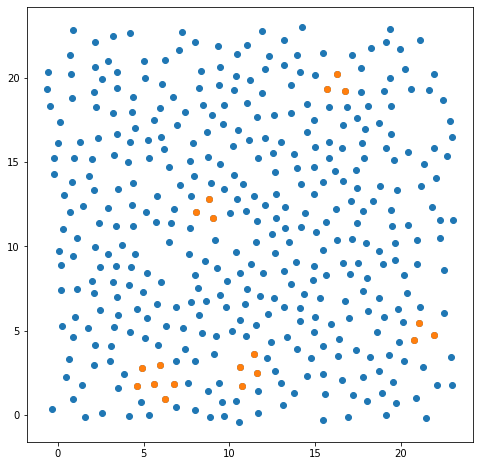

In [62]:
e_coord = coord[great_ind]
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(coord[:,0], coord[:,1])
plt.scatter(e_coord[:,0], e_coord[:,1])

plt.show()

In [49]:
coord_ = []
for j in range(x_extend):
    for k in range(y_extend):
        rand1 = np.random.rand()*1/4-1/8
        rand2 = np.random.rand()*1/4-1/8
        coord_.append([init_dis*j+rand1, init_dis*k+rand2])
        #*Seperate the matrix into several bounded regions
        # region.append([1.12*(j-1/2), 1.12*(j+1/2), 1.12*(k-1/2), 1.12*(k+1/2)])

coord_ = np.array(coord_)